# Libraries

In [25]:
import requests
import time
import schedule
import sqlite3
from datetime import datetime
import unittest
from unittest.mock import patch
import matplotlib.pyplot as plt
import pandas as pd

In [26]:
API_KEY = '6dd0db80189b4becc35ab0ab7cd58fb3'
BASE_URL = 'https://api.openweathermap.org/data/2.5/weather'
CITIES = ['Delhi', 'Mumbai', 'Chennai', 'Bangalore', 'Kolkata', 'Hyderabad']

# Database setup

In [27]:
conn = sqlite3.connect('weather_data.db')
c = conn.cursor()

# Create table if not exists
c.execute('''CREATE TABLE IF NOT EXISTS weather_summary (
    date TEXT,
    city TEXT,
    avg_temp REAL,
    max_temp REAL,
    min_temp REAL,
    dominant_condition TEXT
)''')
conn.commit()

# Function to Fetch Weather Data

In [28]:
def fetch_weather_data(city):
    response = requests.get(BASE_URL, params={'q': city, 'appid': API_KEY})
    if response.status_code == 200:
        data = response.json()
        main_weather = data['weather'][0]['main']
        temp_kelvin = data['main']['temp']
        feels_like_kelvin = data['main']['feels_like']
        humidity = data['main']['humidity']  # Get humidity
        wind_speed = data['wind']['speed']    # Get wind speed
        temp_celsius = temp_kelvin - 273.15
        feels_like_celsius = feels_like_kelvin - 273.15
        timestamp = data['dt']
        
        # Convert Unix timestamp to human-readable format
        date_time = datetime.utcfromtimestamp(timestamp)
        formatted_time = date_time.strftime('%Y-%m-%d %H:%M:%S')

        return {
            'city': city,
            'main': main_weather,
            'temp': temp_celsius,
            'feels_like': feels_like_celsius,
            'humidity': humidity,              # Include humidity in the return data
            'wind_speed': wind_speed,          # Include wind speed in the return data
            'timestamp': formatted_time         # Use the formatted timestamp
        }
    else:
        print(f"Failed to retrieve data for {city}: {response.status_code} {response.text}")
        return None

# Processing and Storing Data

In [29]:
daily_data = {}

def process_weather_data():
    current_date = datetime.now().strftime('%Y-%m-%d')
    for city in CITIES:
        weather_data = fetch_weather_data(city)
        if weather_data:
            city_data = daily_data.get(city, [])
            city_data.append(weather_data)
            daily_data[city] = city_data

def calculate_daily_summary():
    for city, city_data in daily_data.items():
        if city_data:
            temps = [data['temp'] for data in city_data]
            dominant_condition = max(set([data['main'] for data in city_data]), key=[data['main'] for data in city_data].count)

            avg_temp = sum(temps) / len(temps)
            max_temp = max(temps)
            min_temp = min(temps)

            store_daily_summary(city, avg_temp, max_temp, min_temp, dominant_condition)

            # Reset the daily data after processing
            daily_data[city] = []

def store_daily_summary(city, avg_temp, max_temp, min_temp, dominant_condition):
    current_date = datetime.now().strftime('%Y-%m-%d')
    with conn:
        c.execute('''INSERT INTO weather_summary (date, city, avg_temp, max_temp, min_temp, dominant_condition)
                     VALUES (?, ?, ?, ?, ?, ?)''', 
                  (current_date, city, avg_temp, max_temp, min_temp, dominant_condition))
        conn.commit()

# Clear the database before running tests
def clear_database():
    with conn:
        c.execute('DELETE FROM weather_summary')
        conn.commit()

# Visualization

In [30]:
def plot_daily_summary(city):
    # Retrieve data for the specified city from the database
    c.execute("SELECT * FROM weather_summary WHERE city = ?", (city,))
    records = c.fetchall()

    if not records:
        print(f"No records found for {city}.")
        return

    # Prepare data for plotting
    dates = [record[0] for record in records]
    avg_temps = [record[2] for record in records]
    max_temps = [record[3] for record in records]
    min_temps = [record[4] for record in records]

    # Create DataFrame for plotting
    df = pd.DataFrame({
        'Date': pd.to_datetime(dates),
        'Avg Temp': avg_temps,
        'Max Temp': max_temps,
        'Min Temp': min_temps
    })

    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Avg Temp'], marker='o', label='Average Temp (°C)', color='blue')
    plt.plot(df['Date'], df['Max Temp'], marker='o', label='Max Temp (°C)', color='red')
    plt.plot(df['Date'], df['Min Temp'], marker='o', label='Min Temp (°C)', color='green')
    
    plt.title(f"Daily Temperature Summary for {city}")
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Threshold Alerts
# Configure alerts when certain weather conditions or thresholds are met

In [31]:
THRESHOLD_TEMP = 35  # Example threshold for temperature alerts

def check_thresholds():
    for city, city_data in daily_data.items():
        if city_data:
            latest_temp = city_data[-1]['temp']
            if latest_temp > THRESHOLD_TEMP:
                print(f"Alert! Temperature in {city} exceeded {THRESHOLD_TEMP}°C: {latest_temp:.2f}°C")

# Scheduling Tasks

In [32]:
def run_scheduled_tasks():
    print("Starting to fetch live weather data for 5 minutes...")

    # Immediately fetch weather data before starting the schedule
    process_weather_data()

    start_time = time.time()  # Record the start time
    while True:
        schedule.run_pending()  # Run any scheduled tasks
        time.sleep(1)  # Wait for 1 second before checking again

        # Check if 5 minutes have passed
        if time.time() - start_time >= 300:  # 300 seconds = 5 minutes
            print("\nLive Weather Data:")
            for city, data in daily_data.items():
                if data:
                    latest_data = data[-1]  # Get the latest data for the city
                    print(f"City: {latest_data['city']}, "
                          f"Latest Temperature: {latest_data['temp']:.2f}°C, "
                          f"Condition: {latest_data['main']}, "
                          f"Feels Like: {latest_data['feels_like']:.2f}°C, "
                          f"Humidity: {latest_data['humidity']}%, "
                          f"Wind Speed: {latest_data['wind_speed']} m/s, "
                          f"Timestamp: {latest_data['timestamp']}")
                    
                    # Plot the daily summary for each city
                    plot_daily_summary(city)
                else:
                    print(f"No data available for {city}.")
                    
            print("Finished running scheduled tasks for 5 minutes.")
            break  # Exit the loop after 5 minutes

Starting to fetch live weather data for 5 minutes...

Live Weather Data:
City: Delhi, Latest Temperature: 31.05°C, Condition: Haze, Feels Like: 32.90°C, Humidity: 51%, Wind Speed: 3.09 m/s, Timestamp: 2024-10-20 06:04:09


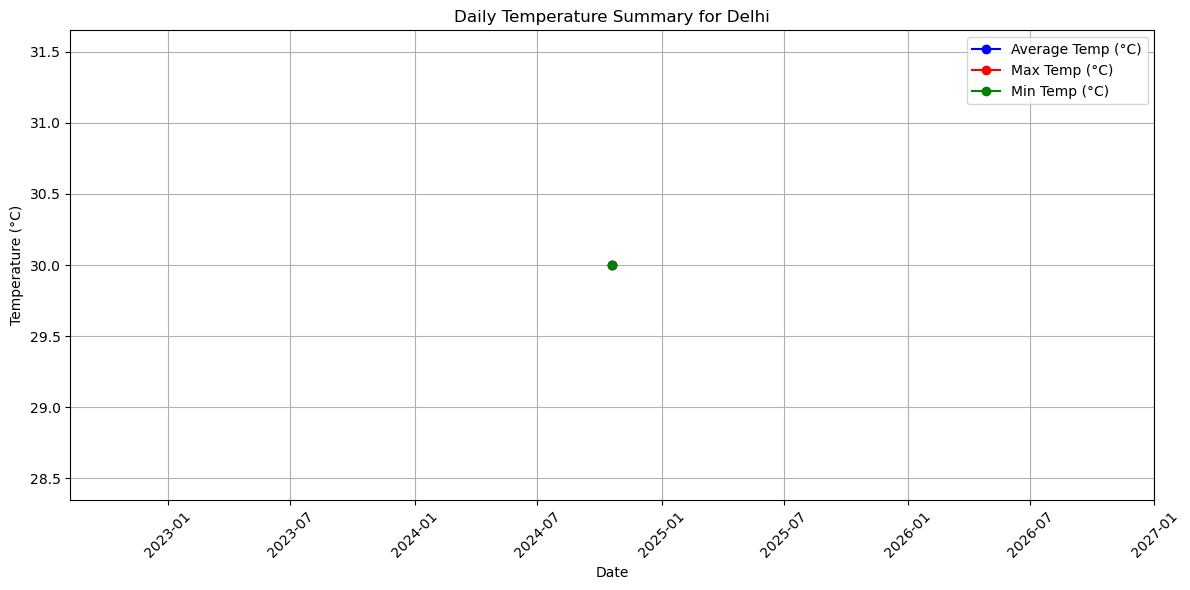

City: Mumbai, Latest Temperature: 30.99°C, Condition: Haze, Feels Like: 35.33°C, Humidity: 62%, Wind Speed: 1.54 m/s, Timestamp: 2024-10-20 06:03:47


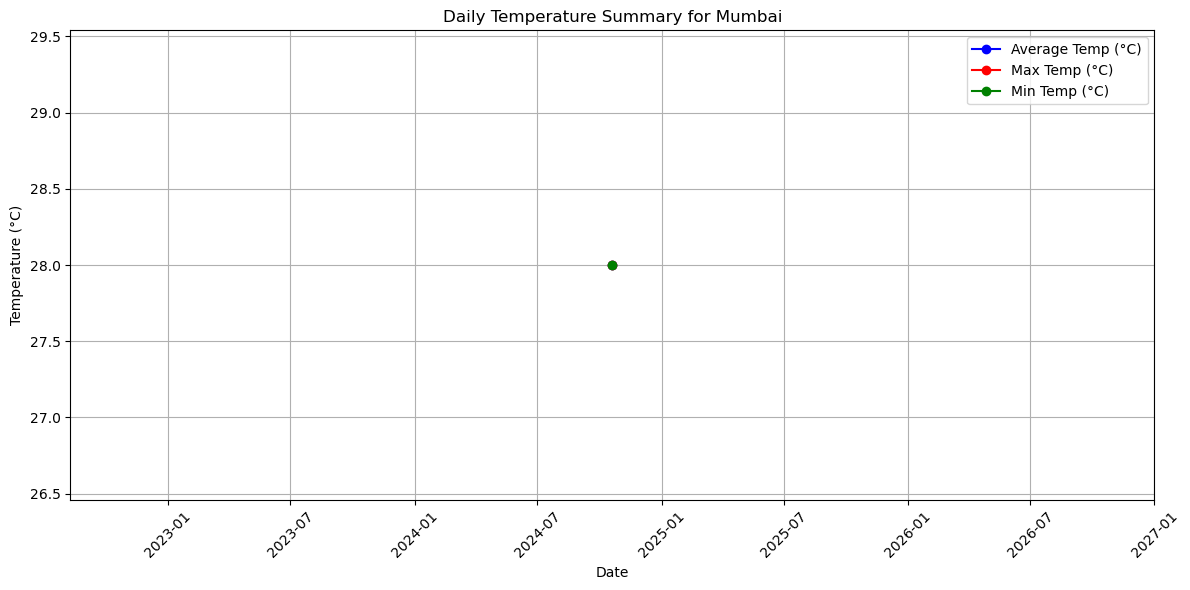

City: Chennai, Latest Temperature: 30.39°C, Condition: Mist, Feels Like: 37.39°C, Humidity: 83%, Wind Speed: 3.58 m/s, Timestamp: 2024-10-20 06:05:03


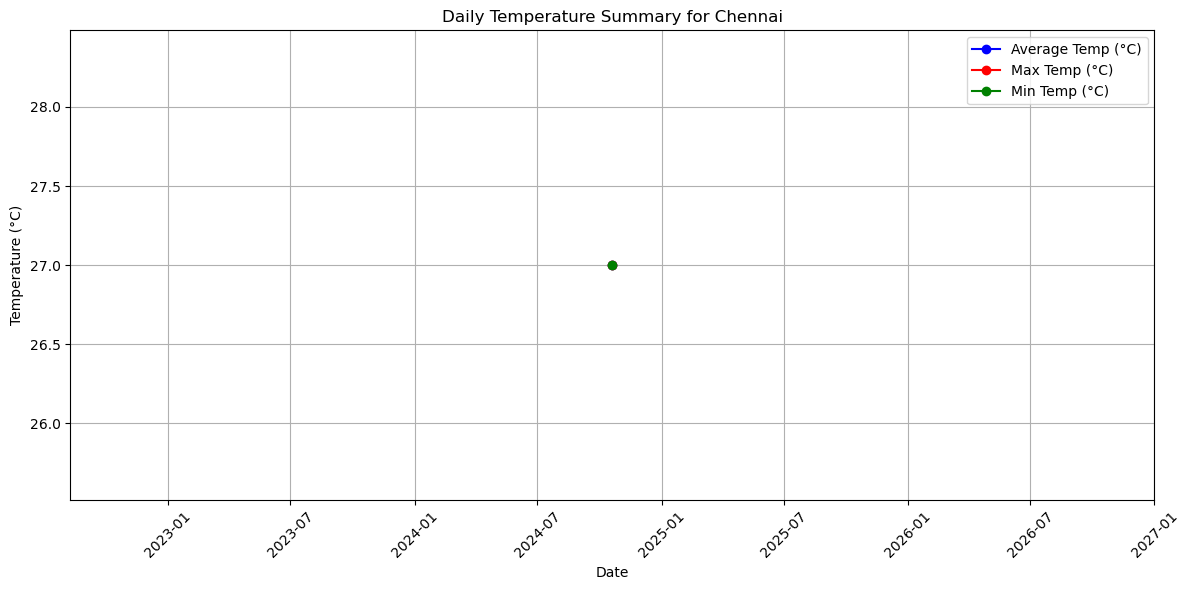

City: Bangalore, Latest Temperature: 26.83°C, Condition: Clouds, Feels Like: 28.96°C, Humidity: 75%, Wind Speed: 1.54 m/s, Timestamp: 2024-10-20 06:05:03


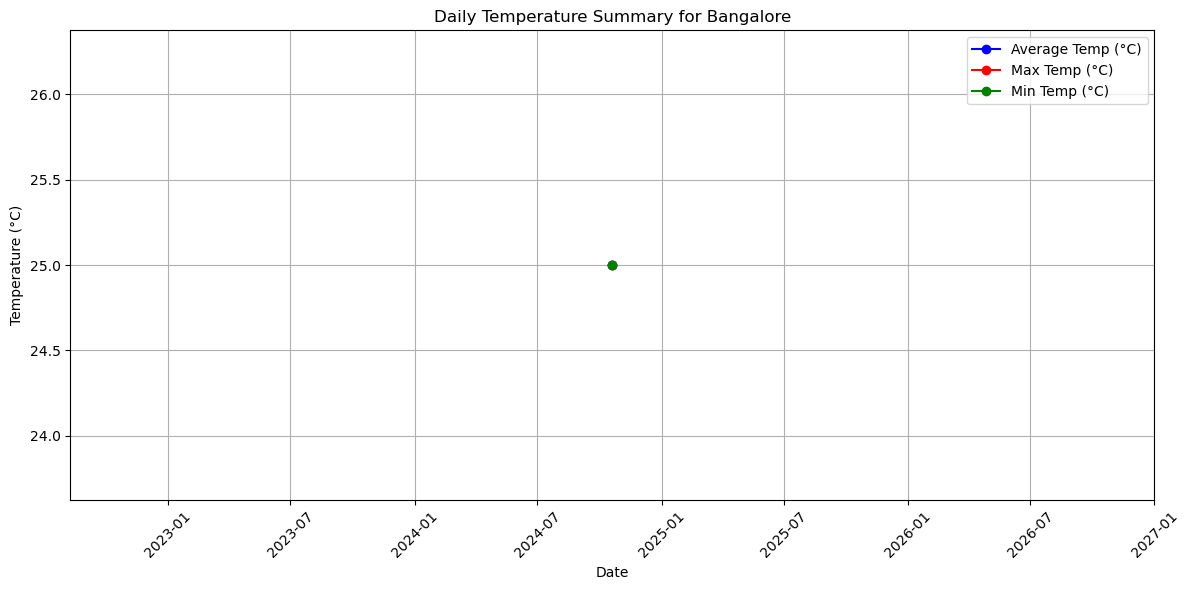

City: Kolkata, Latest Temperature: 30.97°C, Condition: Haze, Feels Like: 36.36°C, Humidity: 66%, Wind Speed: 4.12 m/s, Timestamp: 2024-10-20 06:06:24


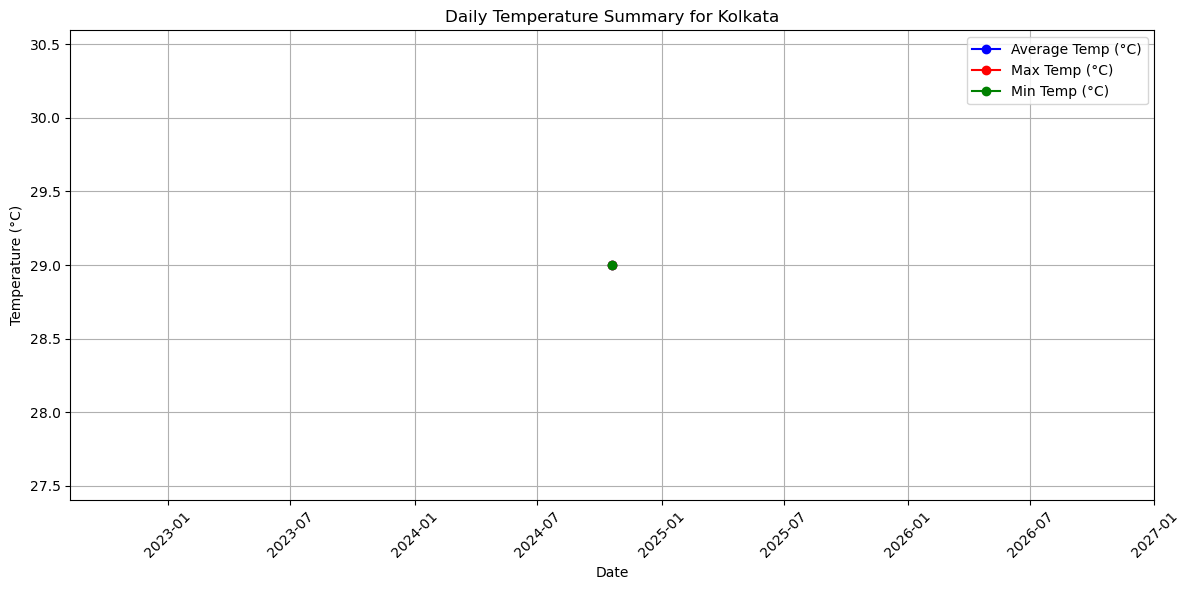

City: Hyderabad, Latest Temperature: 28.23°C, Condition: Haze, Feels Like: 30.98°C, Humidity: 69%, Wind Speed: 2.06 m/s, Timestamp: 2024-10-20 06:00:32


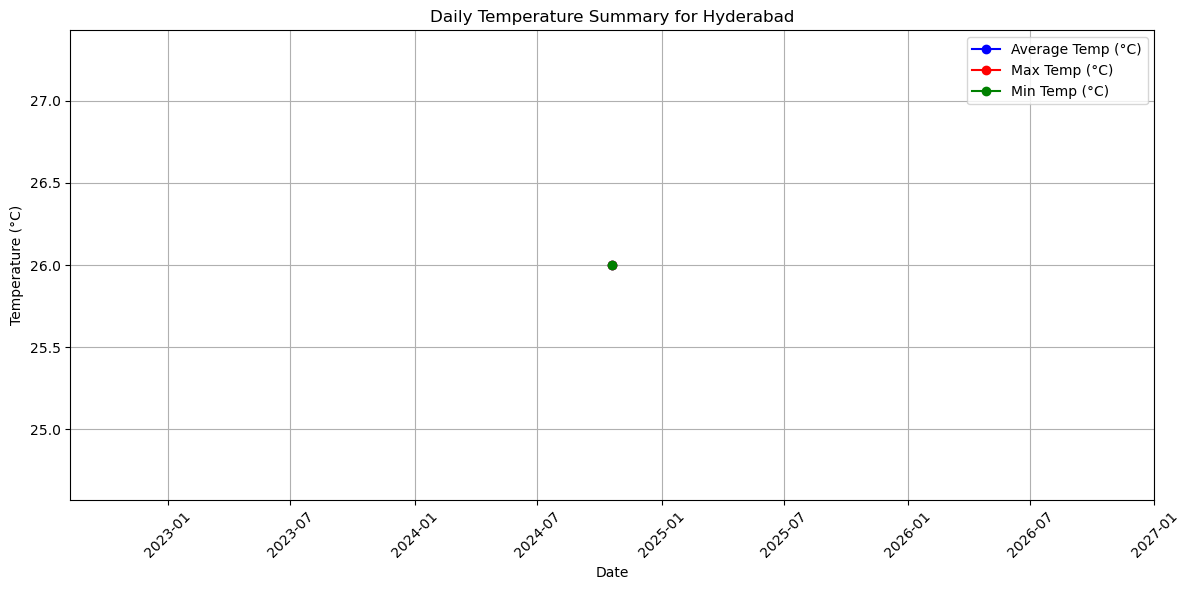

Finished running scheduled tasks for 5 minutes.


In [33]:
if __name__ == "__main__":
    run_scheduled_tasks()